In [1]:
# MIT License

# Copyright (c) 2020 Daniel Bourke

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

In [ ]:
# GitHub: https://github.com/mrdbourke/tensorflow-deep-learning

# Project 2: SkimLit: Natural Language Processing

# Get workspace ready

In [2]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

TF version: 2.15.0
TF Hub version: 0.16.1


In [4]:
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU not available


In [5]:
import os
import datetime
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

# 1.Data pre-processing

## Download and visualize text dataset

In [6]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [7]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [8]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [9]:
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [10]:
def get_lines(filename):

  with open(filename, "r") as f:
    return f.readlines()

In [11]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [12]:
def preprocess_text_with_line_numbers(filename):

  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    else:
      abstract_lines += line

  return abstract_samples

In [13]:
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [14]:
train_samples[:1]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11}]

In [15]:
val_samples[:1]

[{'target': 'BACKGROUND',
  'text': 'ige sensitization to aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
  'line_number': 0,
  'total_lines': 9}]

In [16]:
test_samples[:1]

[{'target': 'BACKGROUND',
  'text': 'this study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( adhf ) .',
  'line_number': 0,
  'total_lines': 8}]

In [17]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [18]:
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<Axes: ylabel='Frequency'>

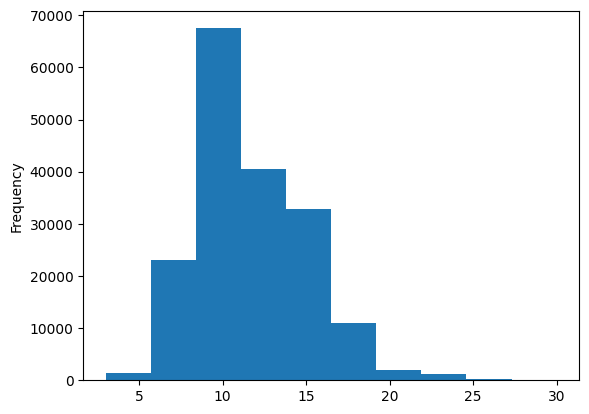

In [19]:
train_df.total_lines.plot.hist()

## Get lists of sentences

In [20]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [21]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels

In [22]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [23]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [24]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# 1.Model 0: baseline model

## Building a model

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([("tf-idf", TfidfVectorizer()), ("clf", MultinomialNB())])

model_0.fit(X=train_sentences, y=train_labels_encoded);

## Model evaluation

In [26]:
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

## Prediction

In [27]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [28]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):

  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [29]:
baseline_results = calculate_results(y_true=val_labels_encoded, y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# 2.Model 1: Conv1D with token embeddings

In [30]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

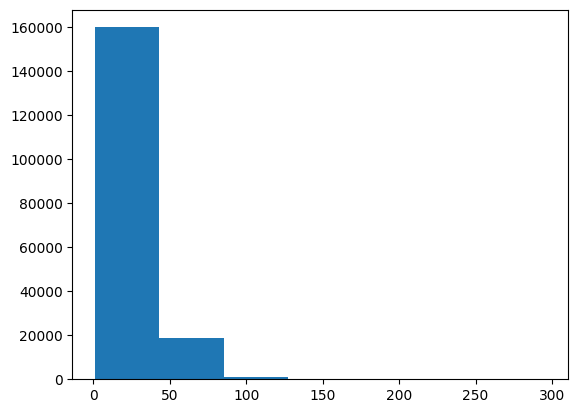

In [31]:
plt.hist(sent_lens, bins=7);

In [32]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [33]:
max(sent_lens)

296

## Convert text into numbers using text vectorization

In [34]:
max_tokens = 68000

In [35]:
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, output_sequence_length=55)

In [36]:
text_vectorizer.adapt(train_sentences)

In [37]:
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
this study is a randomized prospective research .

Length of text: 8

Vectorized text:
[[ 23  17  20   8  29 241 285   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]


In [38]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [39]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Creating custom text embedding

In [40]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), output_dim=128, mask_zero=True, name="token_embedding")

print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
this study is a randomized prospective research .

Sentence after vectorization (before embedding):
[[ 23  17  20   8  29 241 285   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]

Sentence after embedding:
[[[-0.03965958  0.03456874  0.03552133 ... -0.03991545  0.01530436
    0.02202429]
  [-0.04102384 -0.01233627  0.02175028 ...  0.00220333  0.02186196
   -0.03217383]
  [ 0.01596973 -0.0475518  -0.04456483 ...  0.01976598  0.0487042
    0.04785517]
  ...
  [ 0.04168619 -0.03505691  0.03300374 ... -0.00694776  0.04190756
    0.02775861]
  [ 0.04168619 -0.03505691  0.03300374 ... -0.00694776  0.04190756
    0.02775861]
  [ 0.04168619 -0.03505691  0.03300374 ... -0.00694776  0.04190756
    0.02775861]]]

Embedded sentence shape: (1, 55, 128)


## Creating datasets

In [41]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [42]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Building a model

In [43]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [44]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [45]:
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 102s 179ms/step - loss: 0.9204 - accuracy: 0.6356 - val_loss: 0.6926 - val_accuracy: 0.7330
Epoch 2/3
562/562 [==============================] - 99s 176ms/step - loss: 0.6639 - accuracy: 0.7549 - val_loss: 0.6356 - val_accuracy: 0.7696
Epoch 3/3
562/562 [==============================] - 90s 160ms/step - loss: 0.6224 - accuracy: 0.7739 - val_loss: 0.6003 - val_accuracy: 0.7846


## Model evaluation

In [46]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 9s 10ms/step - loss: 0.6034 - accuracy: 0.7848


[0.6033672094345093, 0.7847874760627747]

## Prediction

In [47]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 9s 9ms/step


array([[4.3934253e-01, 1.8100896e-01, 7.8975216e-02, 2.7803817e-01,
        2.2635072e-02],
       [4.2099431e-01, 3.0608177e-01, 1.2935059e-02, 2.5279516e-01,
        7.1937758e-03],
       [1.5086323e-01, 1.1567074e-02, 1.8503083e-03, 8.3569634e-01,
        2.3005814e-05],
       ...,
       [5.8647333e-06, 9.2443690e-04, 7.5707515e-04, 2.0975265e-06,
        9.9831057e-01],
       [5.4287504e-02, 4.2098039e-01, 1.0578679e-01, 7.3446229e-02,
        3.4549910e-01],
       [2.0767412e-01, 6.0408366e-01, 3.7126984e-02, 6.3005880e-02,
        8.8109359e-02]], dtype=float32)

In [48]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [49]:
model_1_results = calculate_results(y_true=val_labels_encoded, y_pred=model_1_preds)
model_1_results

{'accuracy': 78.47875016549716,
 'precision': 0.7812568994960584,
 'recall': 0.7847875016549716,
 'f1': 0.7820696676760308}

# 3.Model 2: Feature extraction with pretrained token embeddings

In [50]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=False, name="universal_sentence_encoder")

In [51]:
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")

use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
varenicline partially mimicked this effect of smoking but also reduced the smoking-induced increase , indicating a role for @ nachrs .

Sentence after embedding:
[-2.4728414e-03  5.4662663e-02  2.4213925e-02 -8.2368448e-02
 -5.9658181e-02  1.5809525e-02 -4.7318723e-02 -1.4777624e-02
  6.4688869e-02  7.0175663e-02 -5.8522892e-05 -4.1704778e-02
  6.0151752e-02  4.2693257e-02  3.2732926e-02 -3.1125659e-02
 -1.0395176e-02 -3.6600389e-02  1.9489357e-03  6.5934472e-04
 -5.8820143e-02  4.9483232e-02 -5.5707522e-02 -9.1590285e-03
  5.6072772e-03  4.3152265e-02  4.2041659e-02 -6.5673731e-02
  1.6215384e-02  7.0790008e-02] (truncated output)...

Length of sentence embedding:
512


## Building a model

In [52]:
# !pip install tensorflow==2.15.0       ### restart session

In [53]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(5, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [54]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [55]:
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 25s 33ms/step - loss: 0.9176 - accuracy: 0.6520 - val_loss: 0.7965 - val_accuracy: 0.6898
Epoch 2/3
562/562 [==============================] - 14s 25ms/step - loss: 0.7699 - accuracy: 0.7009 - val_loss: 0.7541 - val_accuracy: 0.7051
Epoch 3/3
562/562 [==============================] - 18s 32ms/step - loss: 0.7527 - accuracy: 0.7120 - val_loss: 0.7383 - val_accuracy: 0.7174


## Model evaluation

In [56]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 27s 29ms/step - loss: 0.7419 - accuracy: 0.7142


[0.7418580651283264, 0.7141532897949219]

## Prediction

In [57]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 18s 18ms/step


array([[4.4285071e-01, 3.3823821e-01, 1.6655379e-03, 2.0958903e-01,
        7.6563614e-03],
       [3.3903366e-01, 5.3160834e-01, 3.1624157e-03, 1.2411309e-01,
        2.0824892e-03],
       [2.3294453e-01, 1.5738814e-01, 1.6527971e-02, 5.5238217e-01,
        4.0757168e-02],
       ...,
       [2.0080875e-03, 5.3015403e-03, 5.3374223e-02, 9.1070065e-04,
        9.3840545e-01],
       [3.6935902e-03, 4.4806730e-02, 1.9699748e-01, 1.2900707e-03,
        7.5321215e-01],
       [1.4652300e-01, 2.5672299e-01, 5.3647292e-01, 4.5358371e-03,
        5.5745240e-02]], dtype=float32)

In [58]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [59]:
model_2_results = calculate_results(y_true=val_labels_encoded, y_pred=model_2_preds)
model_2_results

{'accuracy': 71.4153316562955,
 'precision': 0.7142249267812836,
 'recall': 0.7141533165629551,
 'f1': 0.7112324044096185}

# 4.Model 3: Conv1D with character embeddings

In [60]:
def split_chars(text):
  return " ".join(list(text))

split_chars(random_training_sentence)

'v a r e n i c l i n e   p a r t i a l l y   m i m i c k e d   t h i s   e f f e c t   o f   s m o k i n g   b u t   a l s o   r e d u c e d   t h e   s m o k i n g - i n d u c e d   i n c r e a s e   ,   i n d i c a t i n g   a   r o l e   f o r   @   n a c h r s   .'

In [61]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [62]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

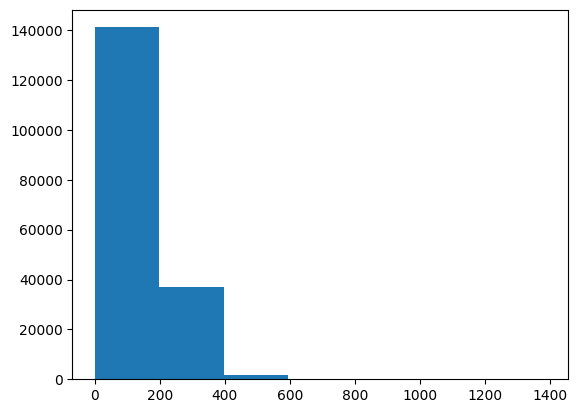

In [63]:
plt.hist(char_lens, bins=7)

In [68]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [69]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

## Creating character-level token vectorizer instance

In [70]:
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")
char_vectorizer.adapt(train_chars)

In [71]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [72]:
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
a s   t h e   s e c o n d a r y   e n d p o i n t   ,   t h e   d e g r e e   o f   d i s c o m f o r t   w a s   i n v e s t i g a t e d   u s i n g   a   q u e s t i o n n a i r e   s u r v e y   a f t e r   c a t h e t e r   r e m o v a l   .

Length of chars: 105

Vectorized chars:
[[ 5  9  3 13  2  9  2 11  7  6 10  5  8 19  2  6 10 14  7  4  6  3  3 13
   2 10  2 18  8  2  2  7 17 10  4  9 11  7 15 17  7  8  3 20  5  9  4  6
  21  2  9  3  4 18  5  3  2 10 16  9  4  6 18  5 26 16  2  9  3  4  7  6
   6  5  4  8  2  9 16  8 21  2 19  5 17  3  2  8 11  5  3 13  2  3  2  8
   8  2 15  7 21  5 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0

## Creating character-level embedding

In [73]:
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, output_dim=25, mask_zero=False, name="char_embed")

print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
a s   t h e   s e c o n d a r y   e n d p o i n t   ,   t h e   d e g r e e   o f   d i s c o m f o r t   w a s   i n v e s t i g a t e d   u s i n g   a   q u e s t i o n n a i r e   s u r v e y   a f t e r   c a t h e t e r   r e m o v a l   .

Embedded chars (after vectorization and embedding):
[[[-0.01207726 -0.04230458 -0.04238215 ...  0.0259181  -0.00154616
    0.02450969]
  [ 0.02064501 -0.04094452 -0.01988654 ...  0.00766333 -0.0036911
    0.03981974]
  [ 0.00956972 -0.02352043  0.03284161 ... -0.02785617  0.01848607
    0.03160762]
  ...
  [ 0.00276443 -0.03658413 -0.00523249 ... -0.03012521 -0.02000816
    0.03640861]
  [ 0.00276443 -0.03658413 -0.00523249 ... -0.03012521 -0.02000816
    0.03640861]
  [ 0.00276443 -0.03658413 -0.00523249 ... -0.03012521 -0.02000816
    0.03640861]]]

Character embedding shape: (1, 290, 25)


## Building a model

In [74]:
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_3_conv1D_char_embedding")

model_3.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [75]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5

In [76]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [77]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 21s 33ms/step - loss: 1.2709 - accuracy: 0.4915 - val_loss: 1.0451 - val_accuracy: 0.5964
Epoch 2/3
562/562 [==============================] - 20s 35ms/step - loss: 1.0054 - accuracy: 0.6009 - val_loss: 0.9399 - val_accuracy: 0.6330
Epoch 3/3
562/562 [==============================] - 15s 27ms/step - loss: 0.9209 - accuracy: 0.6362 - val_loss: 0.8632 - val_accuracy: 0.6719


## Model evaluation

In [78]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 9s 9ms/step - loss: 0.8806 - accuracy: 0.6596


[0.8806484341621399, 0.6596054434776306]

## Prediction

In [79]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 10s 11ms/step


array([[0.22743605, 0.49454182, 0.08278126, 0.1283187 , 0.06692221],
       [0.09148135, 0.75716007, 0.00538626, 0.13222085, 0.01375138],
       [0.04905441, 0.28249115, 0.3912964 , 0.22013633, 0.05702179],
       ...,
       [0.02409278, 0.03749919, 0.11252113, 0.03487485, 0.7910121 ],
       [0.02511601, 0.04981105, 0.6427704 , 0.01689876, 0.2654038 ],
       [0.3888761 , 0.46511543, 0.08137555, 0.04854722, 0.01608569]],
      dtype=float32)

In [80]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 2, ..., 4, 2, 1])>

In [81]:
model_3_results = calculate_results(y_true=val_labels_encoded, y_pred=model_3_preds)
model_3_results

{'accuracy': 65.96054547861777,
 'precision': 0.6534957771082813,
 'recall': 0.6596054547861777,
 'f1': 0.6493160719911648}

# 5.Model 4: hybrid embeddings (combining pretrained token embeddings and character embeddings)

In [82]:
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output)

## Building a model

In [83]:
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output)

char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input], outputs=output_layer, name="model_4_token_and_char_embeddings")

In [84]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

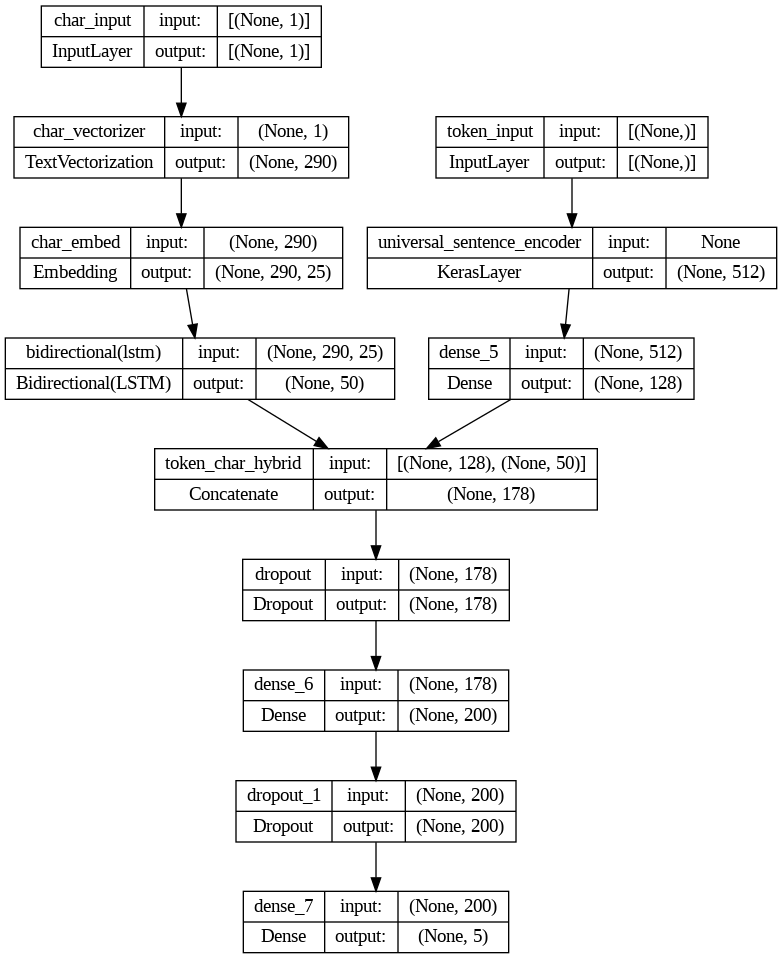

In [85]:
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [86]:
model_4.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

## Combining token and character data into dataset

In [87]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [88]:
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## Building a model

In [89]:
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 228s 383ms/step - loss: 0.9726 - accuracy: 0.6140 - val_loss: 0.7796 - val_accuracy: 0.7028
Epoch 2/3
562/562 [==============================] - 191s 341ms/step - loss: 0.7941 - accuracy: 0.6958 - val_loss: 0.7133 - val_accuracy: 0.7297
Epoch 3/3
562/562 [==============================] - 147s 262ms/step - loss: 0.7615 - accuracy: 0.7101 - val_loss: 0.6863 - val_accuracy: 0.7377


## Model evaluation

In [90]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 59s 62ms/step - loss: 0.6912 - accuracy: 0.7351


[0.6911889910697937, 0.7351383566856384]

## Prediction

In [91]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 58s 59ms/step


array([[4.7867844e-01, 3.5670334e-01, 2.8890406e-03, 1.5465179e-01,
        7.0774513e-03],
       [3.0455473e-01, 5.1627815e-01, 4.5939446e-03, 1.7171039e-01,
        2.8628390e-03],
       [2.9748532e-01, 6.1056346e-02, 2.7157130e-02, 5.9858340e-01,
        1.5717775e-02],
       ...,
       [8.0275472e-04, 1.1958649e-02, 4.9134061e-02, 2.4049306e-04,
        9.3786407e-01],
       [5.4758475e-03, 5.6502301e-02, 1.8787387e-01, 2.5040472e-03,
        7.4764389e-01],
       [3.8316804e-01, 2.7420861e-01, 2.8044379e-01, 2.8580692e-02,
        3.3598952e-02]], dtype=float32)

In [92]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 0])>

In [92]:
model_4_results = calculate_results(y_true=val_labels_encoded, y_pred=model_4_preds)
model_4_results

# 6.Model 5: Transfer learning with pretrained token + character + positional embeddings

In [92]:
train_df.head()

In [93]:
train_df["line_number"].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

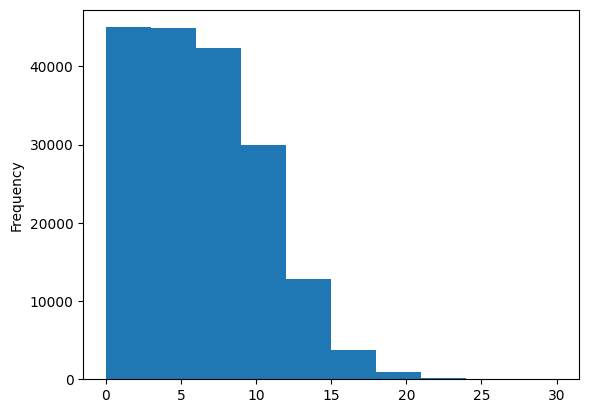

In [94]:
train_df.line_number.plot.hist()

## Create positional embeddings

In [95]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [96]:
train_line_numbers_one_hot

<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [97]:
val_line_numbers_one_hot

<tf.Tensor: shape=(30212, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)>

In [98]:
test_line_numbers_one_hot

<tf.Tensor: shape=(30135, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [99]:
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

In [100]:
train_df["total_lines"].value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


<Axes: ylabel='Frequency'>

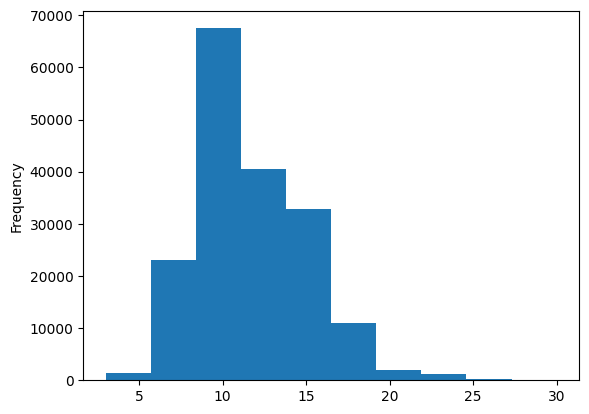

In [101]:
train_df.total_lines.plot.hist()

In [102]:
np.percentile(train_df.total_lines, 98)

20.0

In [103]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

## Building a model

In [104]:
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=x)

total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs, outputs=y)

combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output, total_line_model.output, z])

output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

model_5 = tf.keras.Model(inputs=[line_number_model.input, total_line_model.input, token_model.input, char_model.input], outputs=output_layer)

In [105]:
model_5.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']  

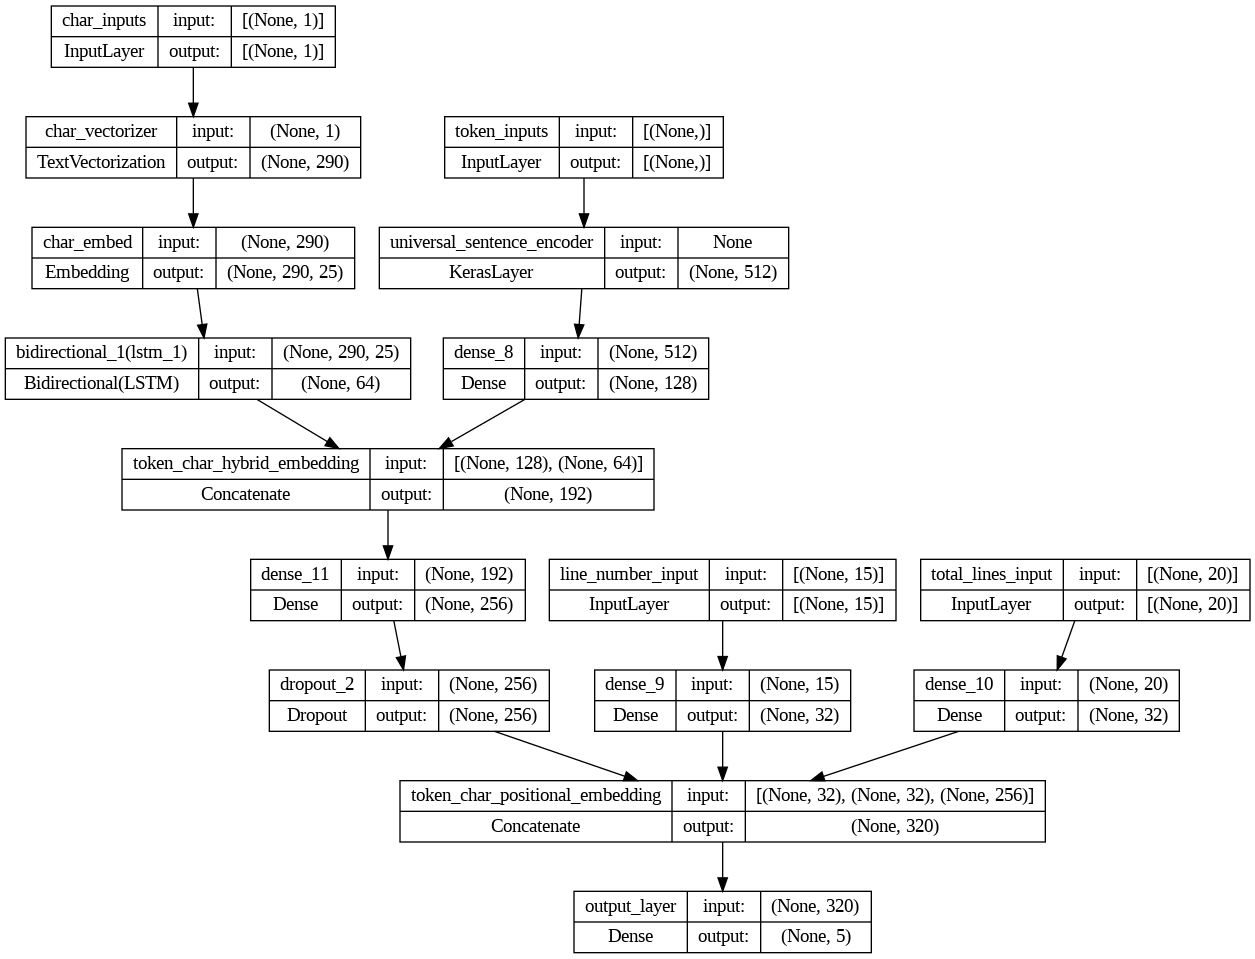

In [106]:
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [107]:
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7cd3368b4e10> True
<keras.src.engine.input_layer.InputLayer object at 0x7cd332e13910> True
<keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x7cd3a9d1db50> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7cd3a8412f90> False
<keras.src.layers.core.embedding.Embedding object at 0x7cd39696c1d0> True
<keras.src.layers.core.dense.Dense object at 0x7cd336ac7d10> True
<keras.src.layers.rnn.bidirectional.Bidirectional object at 0x7cd33689f0d0> True
<keras.src.layers.merging.concatenate.Concatenate object at 0x7cd33652c150> True
<keras.src.engine.input_layer.InputLayer object at 0x7cd336872bd0> True
<keras.src.engine.input_layer.InputLayer object at 0x7cd33683d850> True
<keras.src.layers.core.dense.Dense object at 0x7cd3368732d0> True
<keras.src.layers.core.dense.Dense object at 0x7cd336526c90> True
<keras.src.layers.core.dense.Dense object at 0x7cd336556490> True
<keras.src.layers.regularization.dropout.

In [108]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

## Create tribid embedding dataset

In [109]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, train_total_lines_one_hot, train_sentences, train_chars))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, val_total_lines_one_hot, val_sentences, val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [110]:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 169s 287ms/step - loss: 1.0969 - accuracy: 0.7219 - val_loss: 0.9840 - val_accuracy: 0.8068
Epoch 2/3
562/562 [==============================] - 216s 385ms/step - loss: 0.9664 - accuracy: 0.8193 - val_loss: 0.9468 - val_accuracy: 0.8288
Epoch 3/3
562/562 [==============================] - 174s 309ms/step - loss: 0.9476 - accuracy: 0.8252 - val_loss: 0.9384 - val_accuracy: 0.8275


## Model evaluation

In [111]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 61s 62ms/step


array([[0.49889958, 0.10320765, 0.00957385, 0.37066275, 0.01765627],
       [0.5294022 , 0.10238552, 0.04579034, 0.3122554 , 0.01016653],
       [0.24406457, 0.10786285, 0.10295077, 0.4877328 , 0.05738903],
       ...,
       [0.03348809, 0.10157219, 0.03810867, 0.03215051, 0.79468054],
       [0.02834551, 0.3106039 , 0.06014421, 0.02752579, 0.57338065],
       [0.19831264, 0.5750351 , 0.12667447, 0.04128145, 0.05869635]],
      dtype=float32)

## Prediction

In [112]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [113]:
model_5_results = calculate_results(y_true=val_labels_encoded, y_pred=model_5_preds)
model_5_results

{'accuracy': 83.15569972196478,
 'precision': 0.8306273793181259,
 'recall': 0.8315569972196478,
 'f1': 0.8309114546093957}

# 7.Comparision performance

In [115]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

NameError: name 'model_4_results' is not defined

In [ ]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

In [ ]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

In [ ]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

## Save and load best performing model

In [ ]:
model_5.save("skimlit_tribrid_model")

In [63]:
# !wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
# !mkdir skimlit_gs_model
# !unzip skimlit_tribrid_model.zip -d skimlit_gs_model

In [63]:
from tensorflow.keras.layers import TextVectorization

model_path = "skimlit_tribrid_model/"
loaded_model = tf.keras.models.load_model(model_path)

## Make preditions and evaluation

In [63]:
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

In [63]:
loaded_model_results = calculate_results(val_labels_encoded, loaded_preds)
loaded_model_results

In [63]:
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()), rtol=1e-02)

In [63]:
loaded_model.summary()

# 8.Evaluate model on test dataset

In [ ]:
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot, test_total_lines_one_hot, test_sentences, test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_pos_char_token_dataset

In [ ]:
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset, verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

In [ ]:
loaded_model_test_results = calculate_results(y_true=test_labels_encoded, y_pred=test_preds)
loaded_model_test_results

# 9.Find most wrong

In [ ]:
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

In [ ]:
test_df["prediction"] = test_pred_classes
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy()
test_df["correct"] = test_df["prediction"] == test_df["target"]
test_df.head(25)

In [ ]:
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

In [ ]:
for row in top_100_wrong[0:10].itertuples():
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

# 10.Make example prediction

In [ ]:
import json
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

In [ ]:
with open("skimlit_example_abstracts1.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

In [ ]:
abstracts = pd.DataFrame(example_abstracts)
abstracts

In [ ]:
from spacy.lang.en import English

nlp = English()
sentencizer = nlp.add_pipe("sentencizer")
doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)]
abstract_lines

In [ ]:
total_lines_in_sample = len(abstract_lines)

sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

In [ ]:
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

In [ ]:
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

In [ ]:
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

In [ ]:
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

In [ ]:
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

In [ ]:
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

In [ ]:
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")